In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sqlite3
from scipy.stats import mannwhitneyu

warnings.filterwarnings('ignore')

In [4]:
holidays = pd.read_csv('all_holiday_dates.csv')
holidays

,holyDate
0,2023-01-01
1,2023-01-06
2,2023-04-07
3,2023-04-09
4,2023-04-10
5,2023-05-01
6,2023-05-18
7,2023-05-28
8,2023-06-23
9,2023-06-24


In [5]:
conn = sqlite3.connect('mock_DG.db')

In [6]:
orders = pd.read_sql_query('SELECT * FROM orders', conn)
orders.head()

,id,createdAt,userId,quantity,refunded,currency,sales,providerId
0,4648711062057701806,2023-08-31 10:14:49,833181563296211638,2,0,eur,1000,3518867990385707647
1,1676056141507951956,2023-03-21 17:04:54,7763311846463275691,1,0,eur,400,6413422964860176913
2,7745602867536251060,2023-07-19 09:48:28,8919282109171104948,2,0,eur,680,123356649204044788
3,7319989469562109720,2023-08-10 12:29:01,5785370845306063462,1,0,eur,1099,7268869293921836511
4,8979946097528312402,2022-10-03 09:55:15,8918527236425591239,1,0,eur,200,7530970657789428790


In [7]:
providers = pd.read_sql_query('SELECT * FROM providers', conn)
providers.head()

,id,defaultOfferType,country,registeredDate
0,6563612899329659014,meal,fin,2015-11-24 16:33:35
1,8724554181611615450,meal,fin,2016-01-27 00:08:50
2,946161542061641905,meal,fin,2016-02-01 15:03:27
3,7056903344430959871,meal,fin,2016-02-02 14:56:40
4,3497712091356119302,meal,fin,2016-02-03 13:20:29


In [8]:
users = pd.read_sql_query('SELECT * FROM users', conn)
users

,id,country,registeredDate
0,6244948894430711520,FI,2015-11-24 16:31:10
1,7333245412641704133,FI,2015-11-24 16:31:10
2,7387231492403274666,FI,2015-11-24 16:31:10
3,462254365688400616,FI,2015-11-24 16:31:10
4,1895545503734717224,FI,2015-11-24 16:31:10
...,...,...,...
358361,7196092156622441252,FI,2023-11-15 12:45:55
358362,6883201590444718954,SE,2023-11-15 13:05:59
358363,4955549817670357375,FI,2023-11-15 13:24:56
358364,453099225938434358,FI,2023-11-15 13:42:19


In [12]:
orders.isna().sum()

id            0
createdAt     0
userId        0
quantity      0
refunded      0
currency      0
sales         0
providerId    0
is_holiday    0
dtype: int64

In [14]:
providers.isna().sum()

id                  0
defaultOfferType    0
country             0
registeredDate      0
dtype: int64

In [23]:
orders.currency.value_counts()

currency
eur    294671
sek      5300
Name: count, dtype: int64

In [17]:
exchange_rates = {
    'sek': 0.089,  
}

In [18]:
def convert_to_euro(row):
    if row['currency'] == 'eur':
        return row['sales']
    else:
        exchange_rate = exchange_rates.get(row['currency'], 1) 
        return row['sales'] * exchange_rate

In [19]:
orders['createdAt'] = pd.to_datetime(orders['createdAt'])
orders['sales'] = orders['sales'].astype('float')
holidays['holyDate'] = pd.to_datetime(holidays['holyDate'])
orders['is_holiday'] = orders['createdAt'].dt.date.isin(holidays['holyDate'].dt.date)
orders['correct_sales'] = orders.apply(convert_to_euro, axis=1)

In [20]:
orders.head()

,id,createdAt,userId,quantity,refunded,currency,sales,providerId,is_holiday,correct_sales
0,4648711062057701806,2023-08-31 10:14:49,833181563296211638,2,0,eur,1000.0,3518867990385707647,False,1000.0
1,1676056141507951956,2023-03-21 17:04:54,7763311846463275691,1,0,eur,400.0,6413422964860176913,False,400.0
2,7745602867536251060,2023-07-19 09:48:28,8919282109171104948,2,0,eur,680.0,123356649204044788,False,680.0
3,7319989469562109720,2023-08-10 12:29:01,5785370845306063462,1,0,eur,1099.0,7268869293921836511,False,1099.0
4,8979946097528312402,2022-10-03 09:55:15,8918527236425591239,1,0,eur,200.0,7530970657789428790,False,200.0


In [22]:
orders.correct_sales.mean()

628.6650517883395

In [21]:
average_sales_holiday = orders[orders['is_holiday']]['correct_sales'].mean()
average_sales_non_holiday = orders[~orders['is_holiday']]['correct_sales'].mean()

average_sales_holiday, average_sales_non_holiday

(651.1278336012862, 628.2861477313174)

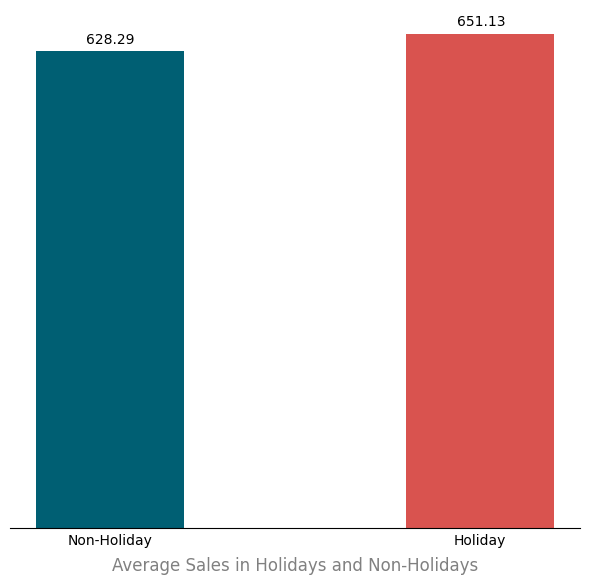

In [30]:
averages = [average_sales_non_holiday, average_sales_holiday]
categories = ['Non-Holiday', 'Holiday']

fig, ax = plt.subplots(figsize=(6, 6))
bars = ax.bar(categories, averages, color=['#005f73', '#d9534f'], width=0.4)

# Adding value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height / 2.8),
                textcoords="offset points",
                ha='center', va='bottom')


ax.set_yticklabels([])
ax.tick_params(length=0)
ax.spines[['right', 'left', 'top']].set_visible(False)
fig.text(0.5, -0.02, 'Average Sales in Holidays and Non-Holidays', ha='center', va='bottom', color='gray', fontsize=12)

plt.tight_layout()
plt.show()

<Axes: ylabel='Frequency'>

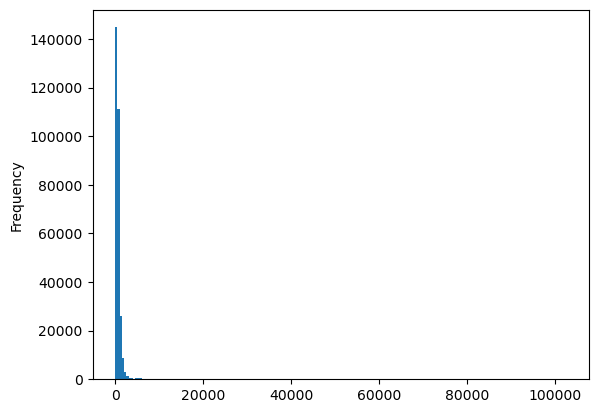

In [24]:
orders['sales'].plot(kind='hist', bins=200)

In [27]:
holiday_sales = orders[orders['is_holiday']]['sales']
non_holiday_sales = orders[~orders['is_holiday']]['sales']

u_stat, p_value_mw = mannwhitneyu(holiday_sales, non_holiday_sales, alternative='two-sided')

u_stat, p_value_mw

(739828037.0, 0.3311821361411026)

The Mann-Whitney U-test results in a U-statistic of approximately 739,828,037 and a p-value of approximately 0.331. The p-value is much greater than the common significance level of 0.05, indicating that we do not have sufficient evidence to reject the null hypothesis that there is no difference in the distributions of sales between holiday and non-holiday periods.

In [32]:
unique_providers_holiday = orders[orders['is_holiday']]['providerId'].nunique()
unique_providers_non_holiday = orders[~orders['is_holiday']]['providerId'].nunique()

unique_providers_holiday, unique_providers_non_holiday


(1206, 3561)

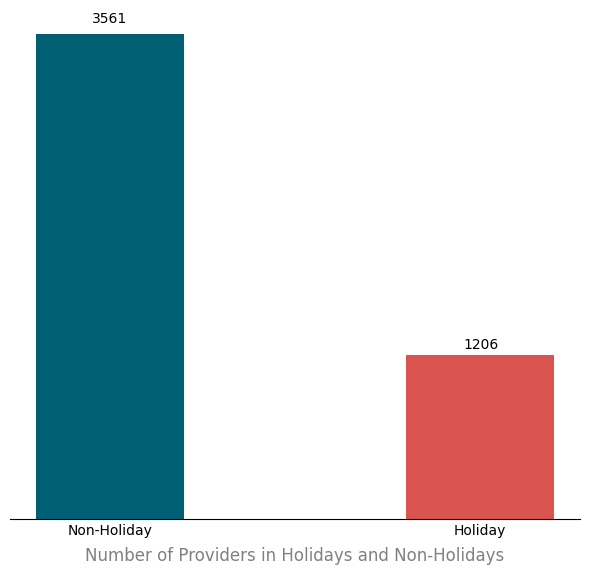

In [38]:
averages = [unique_providers_non_holiday, unique_providers_holiday]
categories = ['Non-Holiday', 'Holiday']

fig, ax = plt.subplots(figsize=(6, 6))
bars = ax.bar(categories, averages, color=['#005f73', '#d9534f'], width=0.4)

# Adding value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height / 11),
                textcoords="offset points",
                ha='center', va='bottom')


ax.set_yticklabels([])
ax.tick_params(length=0)
ax.spines[['right', 'left', 'top']].set_visible(False)
fig.text(0.5, -0.02, 'Number of Providers in Holidays and Non-Holidays', ha='center', va='bottom', color='gray', fontsize=12)

plt.tight_layout()
plt.show()

In [39]:
# Calculate total order volume for holiday and non-holiday periods
total_orders_holiday = orders[orders['is_holiday']].shape[0]
total_orders_non_holiday = orders[~orders['is_holiday']].shape[0]

# Calculate the proportion of orders on holidays vs total orders
total_orders = orders.shape[0]
proportion_orders_holiday = total_orders_holiday / total_orders
proportion_orders_non_holiday = total_orders_non_holiday / total_orders

total_orders_holiday, total_orders_non_holiday, proportion_orders_holiday, proportion_orders_non_holiday


(4976, 294995, 0.016588270199452613, 0.9834117298005474)

In [40]:
# Let's correct the oversight by redefining the necessary parts and performing the calculations in one coherent step.

# Convert 'holyDate' to datetime format again to ensure it's correct
holidays['holyDate'] = pd.to_datetime(holidays['holyDate'])

# Re-identify holiday dates for each year
holiday_dates_2022 = holidays[holidays['holyDate'].dt.year == 2022]
holiday_dates_2023 = holidays[holidays['holyDate'].dt.year == 2023]

# Recalculate the number of holiday days for each year
number_of_holiday_days_2022 = holiday_dates_2022['holyDate'].nunique()
number_of_holiday_days_2023 = holiday_dates_2023['holyDate'].nunique()

# Assume 365 days per year for simplicity to calculate non-holiday days
number_of_non_holiday_days_2022 = 365 - number_of_holiday_days_2022
number_of_non_holiday_days_2023 = 365 - number_of_holiday_days_2023

# Filter the sales data by year
orders_2022 = orders[orders['createdAt'].dt.year == 2022]
orders_2023 = orders[orders['createdAt'].dt.year == 2023]

# Calculate total orders for holiday and non-holiday periods for each year
total_orders_holiday_2022 = orders_2022[orders_2022['is_holiday']].shape[0]
total_orders_non_holiday_2022 = orders_2022[~orders_2022['is_holiday']].shape[0]
total_orders_holiday_2023 = orders_2023[orders_2023['is_holiday']].shape[0]
total_orders_non_holiday_2023 = orders_2023[~orders_2023['is_holiday']].shape[0]

# Calculate the average daily orders for holidays and non-holidays for each year
average_daily_orders_holiday_2022 = total_orders_holiday_2022 / number_of_holiday_days_2022
average_daily_orders_non_holiday_2022 = total_orders_non_holiday_2022 / number_of_non_holiday_days_2022
average_daily_orders_holiday_2023 = total_orders_holiday_2023 / number_of_holiday_days_2023
average_daily_orders_non_holiday_2023 = total_orders_non_holiday_2023 / number_of_non_holiday_days_2023

(number_of_holiday_days_2022, number_of_holiday_days_2023,
 total_orders_holiday_2022, total_orders_non_holiday_2022,
 total_orders_holiday_2023, total_orders_non_holiday_2023,
 average_daily_orders_holiday_2022, average_daily_orders_non_holiday_2022,
 average_daily_orders_holiday_2023, average_daily_orders_non_holiday_2023)

(15,
 15,
 1059,
 61973,
 3917,
 233022,
 70.6,
 177.06571428571428,
 261.1333333333333,
 665.7771428571428)